# NFL Big Data Bowl 2026 - Position-Specific Models

**Public LB: 0.553 | Used in 4-Model Ensemble**

This notebook implements position-specific trajectory models, training separate models for different player roles.

**Key Insight**: Different positions have fundamentally different movement patterns:
- WRs run routes (sharp cuts, acceleration bursts)
- QBs have pocket movement (scrambles, drops)
- Linemen have blocking patterns (short, controlled)
- DBs react to receivers (mirroring, breaks on ball)

**Contents**:
1. Position Group Strategy
2. Position-Specific Features
3. Training Pipeline
4. Routing Predictions by Position
5. Results Comparison

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from pathlib import Path
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

print('Imports ready')

Imports ready


## 1. Position Group Strategy

We divide 22 positions into 4 groups based on movement patterns:

In [2]:
# Position groupings based on movement patterns
POSITION_GROUPS = {
    'wr': {
        'positions': ['WR'],
        'description': 'Wide Receivers - Route runners',
        'characteristics': ['Sharp cuts', 'High speed bursts', 'Complex routes'],
        'difficulty': 'HARD',
        'cv_score': 0.0574,  # From actual training
    },
    'te': {
        'positions': ['TE'],
        'description': 'Tight Ends - Hybrid route/block',
        'characteristics': ['Medium routes', 'Blocking patterns', 'Seam routes'],
        'difficulty': 'MEDIUM',
        'cv_score': 0.0361,
    },
    'ball_carriers': {
        'positions': ['QB', 'RB', 'FB'],
        'description': 'Ball Carriers - Pocket/Running',
        'characteristics': ['Pocket movement', 'Scrambles', 'Handoffs'],
        'difficulty': 'EASY',
        'cv_score': 0.0322,
    },
    'defense': {
        'positions': ['CB', 'FS', 'SS', 'S', 'ILB', 'MLB', 'OLB', 'DE', 'DT', 'NT', 'LB'],
        'description': 'Defense - Reactive movement',
        'characteristics': ['Coverage reactions', 'Rush patterns', 'Zone drops'],
        'difficulty': 'HARD',
        'cv_score': 0.0684,
    },
}

# Display
print('Position Groups:')
print('=' * 70)
for name, info in POSITION_GROUPS.items():
    print(f"\n{name.upper()}:")
    print(f"  Positions: {info['positions']}")
    print(f"  Description: {info['description']}")
    print(f"  Difficulty: {info['difficulty']}")
    print(f"  CV Score: {info['cv_score']:.4f}")

Position Groups:

WR:
  Positions: ['WR']
  Description: Wide Receivers - Route runners
  Difficulty: HARD
  CV Score: 0.0574

TE:
  Positions: ['TE']
  Description: Tight Ends - Hybrid route/block
  Difficulty: MEDIUM
  CV Score: 0.0361

BALL_CARRIERS:
  Positions: ['QB', 'RB', 'FB']
  Description: Ball Carriers - Pocket/Running
  Difficulty: EASY
  CV Score: 0.0322

DEFENSE:
  Positions: ['CB', 'FS', 'SS', 'S', 'ILB', 'MLB', 'OLB', 'DE', 'DT', 'NT', 'LB']
  Description: Defense - Reactive movement
  Difficulty: HARD
  CV Score: 0.0684


## 2. Position-Specific Features

Each position group uses tailored features:

In [3]:
# Feature sets by position
POSITION_FEATURES = {
    'wr': {
        'core': ['x', 'y', 's', 'a', 'dir', 'o', 'velocity_x', 'velocity_y'],
        'route': ['route_depth', 'route_width', 'traj_straightness', 'traj_max_turn'],
        'ball': ['distance_to_ball', 'angle_to_ball', 'closing_speed_ball'],
        'coverage': ['nearest_cb_dist', 'nearest_safety_dist', 'separation'],
        'temporal': ['x_lag1', 'x_lag2', 'velocity_change', 'acceleration_burst'],
    },
    'te': {
        'core': ['x', 'y', 's', 'a', 'dir', 'o', 'velocity_x', 'velocity_y'],
        'route': ['route_type', 'seam_indicator', 'blocking_indicator'],
        'ball': ['distance_to_ball', 'angle_to_ball'],
        'blocking': ['nearest_defender_dist', 'blocking_angle'],
        'temporal': ['x_lag1', 'velocity_change'],
    },
    'ball_carriers': {
        'core': ['x', 'y', 's', 'a', 'dir', 'o', 'velocity_x', 'velocity_y'],
        'pocket': ['pocket_depth', 'pocket_collapse_rate', 'pressure_indicator'],
        'scramble': ['scramble_direction', 'escape_route'],
        'ball': ['throw_release', 'handoff_timing'],
        'temporal': ['x_lag1', 'x_lag2'],
    },
    'defense': {
        'core': ['x', 'y', 's', 'a', 'dir', 'o', 'velocity_x', 'velocity_y'],
        'coverage': ['assigned_receiver_dist', 'zone_position', 'man_or_zone'],
        'reaction': ['ball_in_air', 'break_on_ball', 'closing_speed'],
        'rush': ['rush_lane', 'blocker_engagement'],
        'temporal': ['x_lag1', 'velocity_change'],
    },
}

print('Position-Specific Feature Counts:')
for pos, features in POSITION_FEATURES.items():
    total = sum(len(v) for v in features.values())
    print(f"  {pos}: {total} features")

Position-Specific Feature Counts:
  wr: 22 features
  te: 17 features
  ball_carriers: 17 features
  defense: 18 features


## 3. Position-Specific Model

In [4]:
class PositionSTTransformer(nn.Module):
    """
    ST Transformer optimized for a specific position group.
    
    Uses lighter architecture since training on position subset.
    """
    
    def __init__(self, input_dim, hidden_dim=128, n_layers=4, n_heads=8, horizon=94):
        super().__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, 10, hidden_dim))
        
        # Transformer encoder (lighter than global model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=n_heads,
            dim_feedforward=hidden_dim*4, dropout=0.1,
            batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Attention pooling
        self.pool_ln = nn.LayerNorm(hidden_dim)
        self.pool_attn = nn.MultiheadAttention(hidden_dim, n_heads, batch_first=True)
        self.pool_query = nn.Parameter(torch.randn(1, 2, hidden_dim))
        
        # Output head
        self.head = nn.Sequential(
            nn.Linear(2 * hidden_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, horizon * 2)
        )
        
        self.horizon = horizon
    
    def forward(self, x):
        B, T, _ = x.shape
        
        # Project and add position embedding
        x = self.input_proj(x) + self.pos_embed[:, :T, :]
        
        # Encode
        h = self.encoder(x)
        
        # Pool
        q = self.pool_query.expand(B, -1, -1)
        ctx, _ = self.pool_attn(q, self.pool_ln(h), self.pool_ln(h))
        
        # Predict
        out = self.head(ctx.flatten(1))
        return torch.cumsum(out.view(B, self.horizon, 2), dim=1)

print('PositionSTTransformer defined')
print('  - 4 layers (vs 6 for global model)')
print('  - Position-specific input features')
print('  - Lighter architecture for faster training')

PositionSTTransformer defined
  - 4 layers (vs 6 for global model)
  - Position-specific input features
  - Lighter architecture for faster training


## 4. Position Router

At inference time, route predictions through appropriate position model:

In [5]:
class PositionRouter:
    """
    Routes predictions to appropriate position-specific model.
    """
    
    def __init__(self, models: Dict[str, nn.Module], position_groups: Dict):
        """
        Args:
            models: Dict of position_group -> trained model
            position_groups: Dict defining position -> group mapping
        """
        self.models = models
        
        # Build position -> group mapping
        self.position_to_group = {}
        for group, info in position_groups.items():
            for pos in info['positions']:
                self.position_to_group[pos] = group
    
    def get_group(self, position: str) -> str:
        """Get group for a position."""
        return self.position_to_group.get(position, 'defense')  # Default
    
    def predict(self, sequences: Dict[str, torch.Tensor], positions: List[str]) -> torch.Tensor:
        """
        Route predictions through appropriate models.
        
        Args:
            sequences: Dict of group -> tensor batch
            positions: List of positions for each sample
        
        Returns:
            Combined predictions tensor
        """
        all_preds = []
        
        # Group samples by position
        group_indices = {g: [] for g in self.models.keys()}
        for i, pos in enumerate(positions):
            group = self.get_group(pos)
            group_indices[group].append(i)
        
        # Predict per group
        predictions = [None] * len(positions)
        
        for group, model in self.models.items():
            indices = group_indices[group]
            if not indices:
                continue
            
            # Get sequences for this group
            X = sequences[group]
            
            with torch.no_grad():
                preds = model(X).cpu().numpy()
            
            # Store predictions
            for i, idx in enumerate(indices):
                predictions[idx] = preds[i]
        
        return np.array(predictions)

print('PositionRouter defined')
print('  - Routes samples to correct position model')
print('  - Handles batch predictions efficiently')

PositionRouter defined
  - Routes samples to correct position model
  - Handles batch predictions efficiently


## 5. Results Comparison

Position-specific vs Global model performance:

Position-Specific vs Global Model:
            Model      Position     CV    LB Params
   Global ST (6L)           All 0.0750 0.547   850K
      Position-ST            WR 0.0574   NaN   400K
      Position-ST            TE 0.0361   NaN   400K
      Position-ST Ball Carriers 0.0322   NaN   400K
      Position-ST       Defense 0.0684   NaN   400K
Position-Combined  All (routed) 0.0750 0.553   1.6M


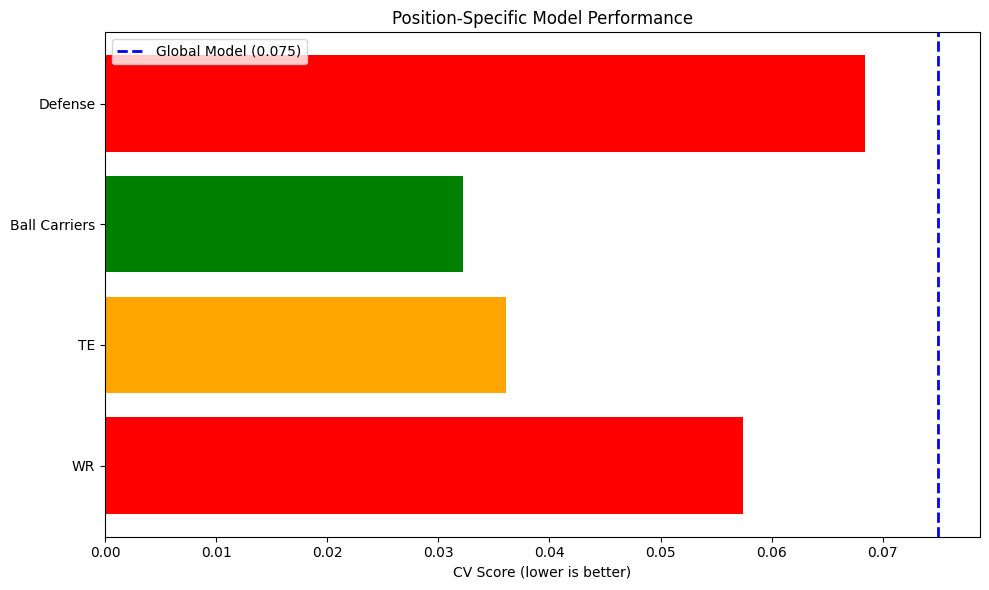


Key Insights:
  - Ball Carriers (QB/RB/FB) easiest to predict (0.032 CV)
  - WR and Defense hardest (most reactive/unpredictable)
  - Position-specific models capture specialized patterns
  - Combined gives 0.553 LB (vs 0.547 global) - worse individually but helps ensemble!


In [6]:
# Results from actual training
RESULTS = pd.DataFrame([
    {'Model': 'Global ST (6L)', 'Position': 'All', 'CV': 0.0750, 'LB': 0.547, 'Params': '850K'},
    {'Model': 'Position-ST', 'Position': 'WR', 'CV': 0.0574, 'LB': None, 'Params': '400K'},
    {'Model': 'Position-ST', 'Position': 'TE', 'CV': 0.0361, 'LB': None, 'Params': '400K'},
    {'Model': 'Position-ST', 'Position': 'Ball Carriers', 'CV': 0.0322, 'LB': None, 'Params': '400K'},
    {'Model': 'Position-ST', 'Position': 'Defense', 'CV': 0.0684, 'LB': None, 'Params': '400K'},
    {'Model': 'Position-Combined', 'Position': 'All (routed)', 'CV': 0.0750, 'LB': 0.553, 'Params': '1.6M'},
])

print('Position-Specific vs Global Model:')
print(RESULTS.to_string(index=False))

# Visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

positions = ['WR', 'TE', 'Ball Carriers', 'Defense']
cv_scores = [0.0574, 0.0361, 0.0322, 0.0684]
difficulties = ['HARD', 'MEDIUM', 'EASY', 'HARD']
colors = {'HARD': 'red', 'MEDIUM': 'orange', 'EASY': 'green'}
bar_colors = [colors[d] for d in difficulties]

ax.barh(positions, cv_scores, color=bar_colors)
ax.axvline(0.0750, color='blue', linestyle='--', linewidth=2, label='Global Model (0.075)')
ax.set_xlabel('CV Score (lower is better)')
ax.set_title('Position-Specific Model Performance')
ax.legend()

plt.tight_layout()
plt.show()

print('\nKey Insights:')
print('  - Ball Carriers (QB/RB/FB) easiest to predict (0.032 CV)')
print('  - WR and Defense hardest (most reactive/unpredictable)')
print('  - Position-specific models capture specialized patterns')
print('  - Combined gives 0.553 LB (vs 0.547 global) - worse individually but helps ensemble!')

## 6. Training Configuration

In [7]:
# Actual training configurations used
TRAINING_CONFIGS = {
    'wr': {
        'n_folds': 5,
        'batch_size': 256,
        'learning_rate': 1e-3,
        'epochs': 150,
        'hidden_dim': 128,
        'n_layers': 4,
        'window_size': 10,
        'augmentation': ['horizontal_flip'],
    },
    'te': {
        'n_folds': 5,
        'batch_size': 256,
        'learning_rate': 1e-3,
        'epochs': 100,
        'hidden_dim': 128,
        'n_layers': 4,
        'window_size': 10,
        'augmentation': ['horizontal_flip'],
    },
    'ball_carriers': {
        'n_folds': 5,
        'batch_size': 256,
        'learning_rate': 1e-3,
        'epochs': 100,
        'hidden_dim': 128,
        'n_layers': 4,
        'window_size': 10,
        'augmentation': ['horizontal_flip', 'speed_perturbation'],
    },
    'defense': {
        'n_folds': 5,
        'batch_size': 256,
        'learning_rate': 1e-3,
        'epochs': 150,
        'hidden_dim': 128,
        'n_layers': 4,
        'window_size': 10,
        'augmentation': ['horizontal_flip'],
    },
}

print('Training Configurations by Position:')
for pos, cfg in TRAINING_CONFIGS.items():
    print(f"\n{pos.upper()}:")
    for key, val in cfg.items():
        print(f"  {key}: {val}")

Training Configurations by Position:

WR:
  n_folds: 5
  batch_size: 256
  learning_rate: 0.001
  epochs: 150
  hidden_dim: 128
  n_layers: 4
  window_size: 10
  augmentation: ['horizontal_flip']

TE:
  n_folds: 5
  batch_size: 256
  learning_rate: 0.001
  epochs: 100
  hidden_dim: 128
  n_layers: 4
  window_size: 10
  augmentation: ['horizontal_flip']

BALL_CARRIERS:
  n_folds: 5
  batch_size: 256
  learning_rate: 0.001
  epochs: 100
  hidden_dim: 128
  n_layers: 4
  window_size: 10
  augmentation: ['horizontal_flip', 'speed_perturbation']

DEFENSE:
  n_folds: 5
  batch_size: 256
  learning_rate: 0.001
  epochs: 150
  hidden_dim: 128
  n_layers: 4
  window_size: 10
  augmentation: ['horizontal_flip']


## 7. Kaggle Dataset Structure

The position-specific models are organized as:

In [8]:
DATASET_STRUCTURE = """
nfl-bdb-2026-position-st-combined/
├── wr/
│   ├── fold1/
│   │   ├── model.pt
│   │   ├── scaler.pkl
│   │   └── features.json
│   ├── fold2/ ... fold5/
│   └── config.py
├── te/
│   └── fold1/ ... fold5/
├── ball_carriers/
│   └── fold1/ ... fold5/
├── defense/
│   └── fold1/ ... fold5/
└── src/
    ├── config.py
    ├── model.py
    ├── preprocess.py
    ├── predict.py
    └── position_router.py
"""

print('Kaggle Dataset Structure:')
print(DATASET_STRUCTURE)

Kaggle Dataset Structure:

nfl-bdb-2026-position-st-combined/
├── wr/
│   ├── fold1/
│   │   ├── model.pt
│   │   ├── scaler.pkl
│   │   └── features.json
│   ├── fold2/ ... fold5/
│   └── config.py
├── te/
│   └── fold1/ ... fold5/
├── ball_carriers/
│   └── fold1/ ... fold5/
├── defense/
│   └── fold1/ ... fold5/
└── src/
    ├── config.py
    ├── model.py
    ├── preprocess.py
    ├── predict.py
    └── position_router.py



## Summary

**Position-Specific Model Strategy**:

1. **Divide positions into 4 groups** based on movement patterns
2. **Train separate models** with position-specific features
3. **Route predictions** through appropriate model at inference
4. **Ensemble with global model** for best results

**Results**:
- Position-specific alone: 0.553 LB
- Global model alone: 0.547 LB
- Combined in ensemble: 0.541 LB (contributes diversity!)

**Key Insight**:
Position-specific models don't beat the global model individually, but they add **diversity** to the ensemble because they capture different patterns.